## PyTorch Workflow

Example of PyTorch end-to-end workflow

Resources: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb


![](screenshots/0_PyTorch_workflow.png)

In [138]:
what_were_covering = {
    1: "Data (preparing and loading)",
    2: "Building mode",
    3: "Fitting the model to the data (training)",
    4: "Making predictions and evaluating a model (inference)",
    5: "Saving and reloading the model",
    6: "Putting it all together"
}

In [139]:
# Dependencies
import torch
from torch import nn # (neural networks)
import matplotlib.pyplot as plt

## 1. Data (preparing and loading)

- Excel spreadsheet
- Images
- Videos
- Audio
- DNA
- Text

Machine Learning has two main parts
1. Get data into a numerical representation
2. Build a model to learn patterns to learn patterns / features / weights in it

![](screenshots/1_ML_2parts.png)

### Creating some "known" data using a linear regression

Creating data from a straight line with *known* **parameters** 

$y = a + bx$

where $a$ is the intersect and $b$ is the slope

In [140]:
# create known parameters
a = 0.3                 # <- bias
b = 0.7                 # <- weights

bias = a
weight = b

# create dataset
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
Y = bias + weight*X
X[:10], Y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [141]:
X.shape, Y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

## Splitting Data into training and test steps

Creating a training and testing set with our data
Taking the 80 - 20 Training testing ratio

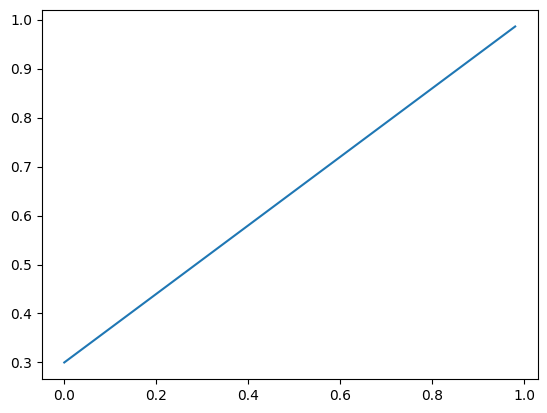

In [142]:
# visualizing the create dataset
plt.plot(X, Y)

In [143]:
# Create a test/train split (using the simplest splitting possible)

train_split = int(0.8*len(X))
X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]

len(X_train), len(X_test)

(40, 10)

In [144]:
X.shape

torch.Size([50, 1])

In [145]:
def plot_predictions(train_data=X_train, train_labels=Y_train,
                    test_data=X_test, test_labels=Y_test,
                    predictions=None):
    """Plots training data, test data and compares predictions """
    
    # plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")
    
    # plot test data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

    # plot predictions
    if not predictions == None:
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

    # show legend
    plt.legend(prop={"size":14})


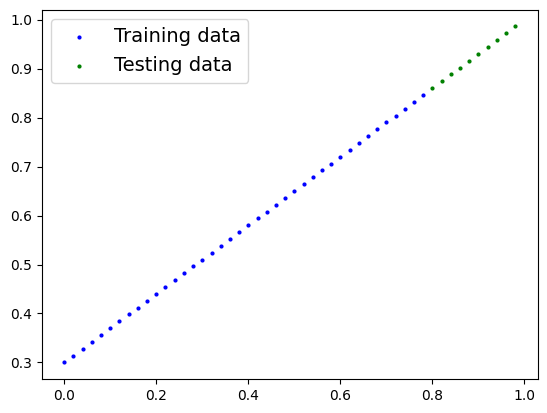

In [146]:
plot_predictions()          # test the plotting function
# ideally, the predictions (red dots) would land exactly on top of the test data dots in green

## 2. Building a model

Linear regression model

We will need two parameters, one for the weight, another for the bias.

What the model will do:
- Start with random values for the parameters
- Look at the training data to get closer to the ideal representation of it by tweaking the parameters

How does it do so?

1. Gradient descent: https://youtu.be/IHZwWFHWa-w
2. Backpropagation:  https://youtu.be/Ilg3gGewQ5U
   1. Algebra: https://www.youtube.com/watch?v=tIeHLnjs5U8

In [147]:
# create a linear regression model class

class LinearRegressionModel(nn.Module): #  <- Almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        """ Deep learning-based linear regression model """

        # initialize the parent class
        super().__init__()
        
        # set weight parameter  
        self.weights = nn.Parameter(torch.randn(1,                      # initialize as a random number
                                                requires_grad=True,     # requires gradient (gradient descent)
                                                dtype=torch.float))     # set datatype    
         # set bias parameter  
        self.bias = nn.Parameter(torch.randn(1,                         # initialize as a random number
                                             requires_grad=True,        # requires gradient (gradient descent)
                                             dtype=torch.float))        # set datatype

    def forward(self, x:torch.tensor) -> torch.tensor:
        """ define the computation in the model"""
        return self.bias + self.weights*x                               # returns the linear regression function

### What's going on under the hood

The `nn` subclass `Module` allows defining a model with all its parameters and methods.

For this simple example, we can explicitly setup the parameters ourselves, but for more complex problems or datasets, this task will be taken care of by PyTorch.

In this case, the gradient descent algorithm will be made smoother for us by `torch.autograd`.
For this, we need to activate the `requires_grad` flag.

#### forward method

The forward method implements the main function of our model, and it always needs to be overridden

## PyTorch model building essentials

* `torch.nn` - contains all building blocks for computational graphs (e.g. neural networks)
* `torch.nn.Parameter` - what parameters should our model try and learn (often a PyTorch layer fromtorch.nn will set these for us)
* `torch.nn.Module` - base class for all neural network model
  * If we subclass it, we need to override the forward command
* `torch.optim` - where the PyTorch optimizers live. Algorithms that optimize the parameters to better represent our daata - they will help with gradient descent
* def forward() - Defines what happens in the forward computation - required to be overridden in any `nn.Module` subclasses

Useful resource: [PyTorch CheatSheet](https://pytorch.org/tutorials/beginner/ptcheat.html)

![](screenshots/2_NN_building_modules.png)

### checking the content of a PyTorch model

Now that the model is created, we can checkout the model parameters ("what's inside of the mode") using `.parameters()`


In [148]:
# create a manual random seed
torch.manual_seed(42)

# create an instance of the linear regression model
model_0 = LinearRegressionModel()

# check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [149]:
# list the named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using Torch.inference_mode()

One can checkout the model's predictive power, by plotting how well the model predicts `y_test` based on `x_test` using the `forward()` method

Inference mode makes the prediction faster by disabling Torch features useful during the training mode, but which are unnecessary in a prediction (inference) context

In [150]:
# make predictions with model

with torch.inference_mode():            # this context manager turns off the gradient tracking
                                        # keeping track of gradients is fundamental for training, 
                                        # but unnecessarily costly during prediction (inference mode)
    Y_preds = model_0(X_test)           # <- call the forward method

# one can also specifically disable the gradient tracking using
with torch.no_grad():
    Y_preds_ng = model_0(X_test)        # expected to be the same as Y_preds

Y_preds_wg = model_0(X_test)            # prediction with gradient tracking

# visualize test and predicted values
for Y in ["Y_test", "Y_preds", "Y_preds_ng", "Y_preds_wg"]:
    print(f"{Y} = {eval(Y).T}")         # notice the difference between the last printed tensor and the others

Y_test = tensor([[0.8600, 0.8740, 0.8880, 0.9020, 0.9160, 0.9300, 0.9440, 0.9580, 0.9720,
         0.9860]])
Y_preds = tensor([[0.3982, 0.4049, 0.4116, 0.4184, 0.4251, 0.4318, 0.4386, 0.4453, 0.4520,
         0.4588]])
Y_preds_ng = tensor([[0.3982, 0.4049, 0.4116, 0.4184, 0.4251, 0.4318, 0.4386, 0.4453, 0.4520,
         0.4588]])
Y_preds_wg = tensor([[0.3982, 0.4049, 0.4116, 0.4184, 0.4251, 0.4318, 0.4386, 0.4453, 0.4520,
         0.4588]], grad_fn=<PermuteBackward0>)


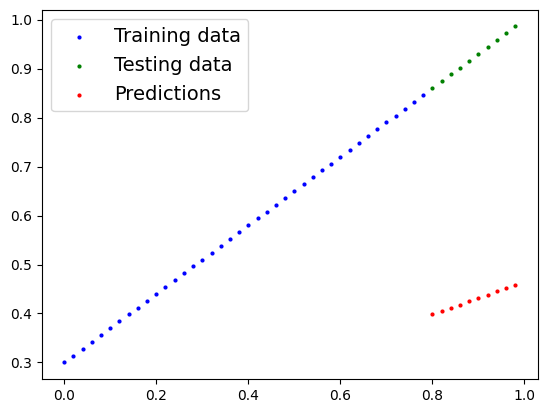

In [151]:
plot_predictions(predictions=Y_preds)   # visualize the predictions


In [152]:
X_train.shape, Y_train.shape

(torch.Size([40, 1]), torch.Size([40, 1]))

## 3. Train module

Changing the model from a poor representation of the data (random parameters) to a better representation (known parameters).

One way to measure the poorness of the model predictions, is to use a **loss** (or cost) function.
There are many loss functions in PyTorch, but the basic concept behind them is the same.

**Important concepts:**

1. **Loss function:** Measuring how wrong the predictions are, relative to the real data
2. **Optimizer:** Takes the model's loss function into account and adjusts the model parameters to minimize it (gradient descent)

Speficically i PyTorch, we need
1. A Training loop
2. A Testing loop

In [153]:
list(model_0.parameters()), model_0.state_dict()

([Parameter containing:
  tensor([0.3367], requires_grad=True),
  Parameter containing:
  tensor([0.1288], requires_grad=True)],
 OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))]))

### Popular loss functions (or criterions)

1. `nn.L1Loss`: Mean absolute error $$L_1 = \frac{\sum|\hat{y} - y|}{n}$$
2. `MSELoss`: Mean squared error $$L_2 = \sqrt{\frac{\sum(\hat{y} - y)^2}{n}}$$

![](screenshots/3_MSE_loss.png)

### Popular optimizer algorithms

1.  **SGD**: Stochastic gradient descent
2.  **Adam**: Iteration on SGD
3.  **BCE**: Binary Cross Entropy loss - classification problems

Optimizer usually take the following arguments:
- `params`: The mode parameters
- `lr`: Learning rate: how abrupt the individual parameter changes are per iteration

In [154]:
# Setup a loss function
loss_fn = nn.L1Loss()                   # Mean Absolute Error or L1

# Setup an optimizer
optimizer = torch.optim.SGD(            # SGD - Stochastic Gradient Descent    
    params=model_0.parameters(),        # mode parameters
    lr=0.01)                            # leaning rate - relative proportion of the learning steps

### Building training and testing loops

Important aspects:
0. Loop through the data
1. Forward pass (propagation) through the model (`forward()` methods - there might be more than one) to make preductions on the data
2. Calculate the loss (compare forward pass predictions against ground truth)
3. Optimizer zero grad- iteration initialization step
4. Loss backward - move back through the network to calculate the gradients of each of the parameters of the model with respect to the loss (back-propagation)
5. Optimizer step - use the optimizer to adjust the model's parameters to minimize the loss (gradient descent)

**Note:** Parameters set by ourselves, such as the **learning rate** and the number of **epochs** is called a hyper-parameter

![](screenshots/4_Training_loop.png)
![](screenshots/5_Training_results.png)

Final state OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
Ground truth: weight=0.7, bias=0.3


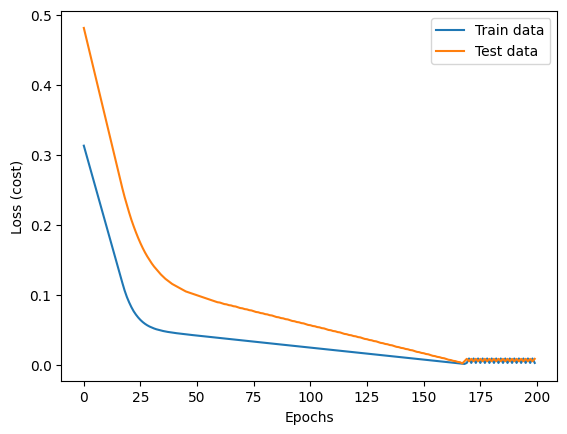

In [155]:
# An epoch is one loop through the data
epochs = 200                                                # move 10 times through the data
losses = []                                                 # store the losses for representation

# Tracking experiments
test_losses = []                                            # losses obtained from the test dataset
print_iteration_results = False                             # step-wise visualization
weights, biases = [], []                                    # model parameter history

## Training the model
# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode - Note how here we cannot use the torch.no_grad() context
    model_0.train()                                         # train mode in PyTorch sets the gradients of all parameters that require parameters

    # 1. Implement the forward pass
    Y_pred = model_0(X_train)                               # this iteration's prediction

    # 2. Calculate the loss
    loss = loss_fn(Y_pred, Y_train)                         # predictions first, target (ground truth) next

    # 3. Optimizer zero grad
    optimizer.zero_grad()                                   # initialize (zero) the cumulative optimizer gradients

    # 4. Perform back-propagation on the loss with respect to the model's parameters
    loss.backward()                                         # mode back propagation
    losses.append(float(loss))                              # store loss for later representation
    if print_iteration_results:                             # iterative printing is active
        if epoch%10 == 0:
            print(f"Loss: {loss}, {model_0.state_dict()}")  # show loss and current state

    # 5. Step optimiz (perform gradient descent)
    optimizer.step()                                        # by default, how the changes will accumulate through the loop

    # Testing
    model_0.eval()                                          # turn off settings in the model not needed for evaluation
    with torch.inference_mode():
        # 1. Do forward pass
        Y_pred = model_0(X_test)                            # forward pass through the optimized mode

        # 2. Calculate the loss
        test_loss = loss_fn(Y_pred, Y_test)                 # loss for data the models hasn't seen yet
        test_losses.append(float(test_loss))                # store losses from test dataset

    # parameter tracking
    weight_i, bias_i = [float(p) for p in model_0.parameters()] # unpack parameter values
    weights.append(weight_i)                                # append weights
    biases.append(bias_i)                                   # append biases

# display training results
print(f"Final state {model_0.state_dict()}")
print(f"Ground truth: weight={weight}, bias={bias}")

plt.plot(losses, label="Train data")
plt.plot(test_losses, label="Test data")
ax = plt.gca()
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss (cost)")
plt.legend()


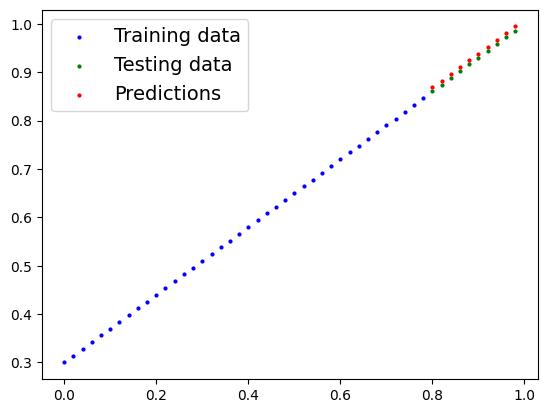

In [156]:
plot_predictions(predictions=Y_pred)

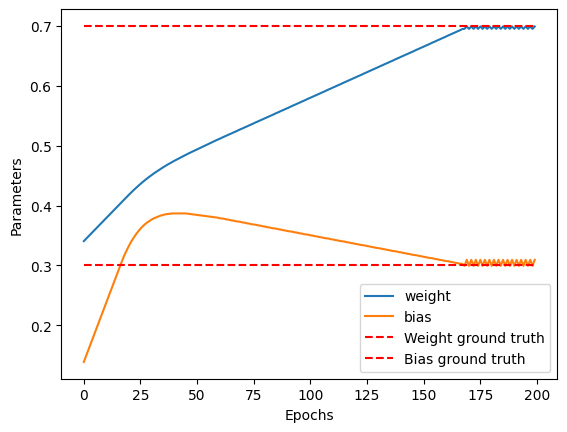

In [157]:
ref =[0, epochs-1]                                              # reference x array
plt.plot(weights, label="weight")                               # show weights
plt.plot(biases, label="bias")                                  # show biases

# show reference ground truths
plt.plot(ref, [weight]*2, '--r', label="Weight ground truth")   # weight ground truth
plt.plot(ref, [bias]*2, '--r', label="Bias ground truth")       # bias ground truth

plt.gca().set_xlabel("Epochs")
plt.gca().set_ylabel("Parameters")
plt.legend()

## Saving a model in PyTorch

There are 3 main mthods for saving and loading models in PyTorch

1. `torch.save()`: Saves the model into a binary Pickle format
2. `torch.load()`: Loads a model from a saved pickle file
3. `torch.nn.Modules.save_state_dict()`: Saves the model's sate dict (contains a static image of the model)
4. `torch.nn.Modules.load_state_dict()`: Loads the model's sate dict

**Note:** The state dict maps each layer of the network to its parameter tensor

In [158]:
# Saving a PyTorch model
from pathlib import Path                            # model to handle paths

# 1. Create a model directory
MODELS_PATH = Path("models")                        # initialize path variable
MODELS_PATH.mkdir(parents=True, exist_ok=True)      # make directory

# 2. Model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"      # define file name
MODEL_SAVE_PATH = MODELS_PATH / MODEL_NAME          # define file path

# 3. Save the model's state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")        # notify user
torch.save(obj=model_0.state_dict(),                # save only state dict
           f=MODEL_SAVE_PATH)                       # specify save path
print("Saved!")                                     # success message

Saving model to: models\01_pytorch_workflow_model_0.pth
Saved!


## Loading a model in PyTorch

One can load the state dict of a model from a file by creating a new instance of the model class, and then loading the saved state dict

In [159]:
# Loading a PyTorch model

# 1. Instantiate model
loaded_model_0 = LinearRegressionModel()                    # instantiate created model

# 2. Load the saved state dict of model_0
loaded_model_0_state_dict = torch.load(f=MODEL_SAVE_PATH)   # load the state dict from file (only saved to var for illustration purposes)
loaded_model_0.load_state_dict(loaded_model_0_state_dict)   # pass it to the imported model 
model_0.state_dict(), loaded_model_0.state_dict()

(OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))]),
 OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))]))

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

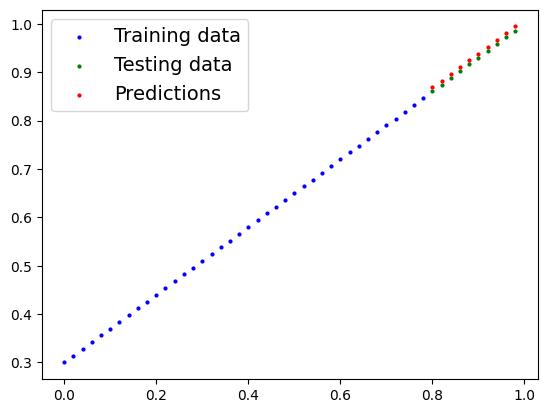

In [160]:
# make predictions with the loaded model
model_0.eval()                                              # set to evaluation mode
loaded_model_0.eval()                                       # set to evaluation mode

with torch.inference_mode():                                # turn off the gradient tracking
    Y_preds = model_0(X_test)                               # calculate predictions from original model
    loaded_model_preds = loaded_model_0(X_test)             # calculate predictions from loaded model
    

plot_predictions(predictions=loaded_model_preds)            # plot predictions

# compare predictions from implemented and loaded models
Y_preds == loaded_model_preds                               # should output a tensor for True's

## Summary

In [161]:
# import Pytorch and Matplolib
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

# check PyTorch version
torch.__version__

'2.0.1+cpu'

In [162]:
# setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device = {device}")

Using device = cpu


### Data

Creating data using the linear regression function

torch.Size([50, 1])

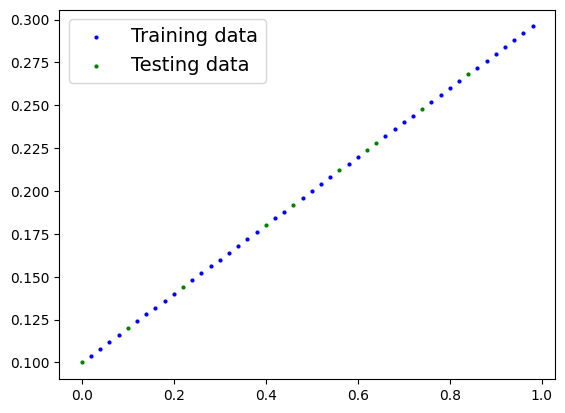

In [163]:
# create data parameters
weight = 0.2                                                            # weight ground truth
bias = 0.1                                                              # bias ground truth

# create data limits
start = 0                                                               # data starting point
end = 1                                                                 # data end point
step = 0.02                                                             # data resolution

# create dataset variables
X = torch.arange(start, end,step).unsqueeze(dim=1)                      # data
#                                 ^^^^^^^^^^^^^^^^ This is important, otherwise the model will fail in the forward pass
Y = X*weight + bias                                                     # labels

# split data
N = len(X)
train_split = int(0.8*N)                                                # length of train dataset

# training sample
np.random.seed(42)                                                      # fix random seed
train_sample = np.array([])                                             # random training sample
while len(train_sample) < train_split:                                  # iteratively sample from data
    subsample_len = train_split - len(train_sample)                     # subsample length
    train_sample = np.unique(np.append(train_sample,                    # update subsample
        (np.random.random(subsample_len)*N).astype(int)))               # get random choice
train_sample = np.sort(train_sample)                                    # sort training sample

# test sample
test_sample = np.array([i for i in range(N) if i not in train_sample])  # test random sample

# train and test datasets
X_train = X[train_sample]                                               # training data
Y_train = Y[train_sample]                                               # training labels
X_test = X[test_sample]                                                 # test data
Y_test = Y[test_sample]                                                 # test labels

plot_predictions(X_train, Y_train, X_test, Y_test)                      # plot train and test data

X.shape

### Building a PyTorch model

In most cases, one does not initialize the parameter manually.
Instead, we can use nn methods that implement layers

A linear layer can also be referred to as:
- linear transform
- probing layer
- fully connected layer
- dense layer

In [164]:
class LinRegModel(nn.Module):                                           # declare new model inheriting from nn.Module
    def __init__(self) -> None:
        """Deep learning-based linear regression model"""
        super().__init__()                                              # initialize parent class               
        
        # initialize layers that have the parameters inbuilt into them
        self.linear_layer = nn.Linear(in_features=1,                    # using the linear layer with 1 input
                                      out_features=1)                   # and 1 output
        
        # as opposed to what was done in the first example:
        # self.weight = nn.parameter(torch.randn(1,                     # initialize as random value
        #                             requires_grad=True),              # activate gradient calculation
        #                             dtype=torch.float32)              # float
        # self.bias = nn.parameter(torch.randn(1,                       # initialize as random value
        #                             requires_grad=True),              # activate gradient calculation
        #                             dtype=torch.float32)              # float

    def forward(self, X:torch.Tensor) -> torch.Tensor:
        """forward pass through the neural network"""
        return self.linear_layer(X)                                     # return linear regression model


# instantiate LinRegModel object
torch.manual_seed(42)                                                   # manually set random seed
model_1 = LinRegModel()                                                 # instantiate LinRegModel

model_1.to(device)                                                      # send model to target device
model_1.state_dict(), next(model_1.parameters()).device                 # print state dict and current device

(OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]),
 device(type='cpu'))

In [165]:
Y_pred = model_1(X_train) 

### Training the model

Requirements:
1. Loss function
2. Optimizer
3. training loop
4. testing loop

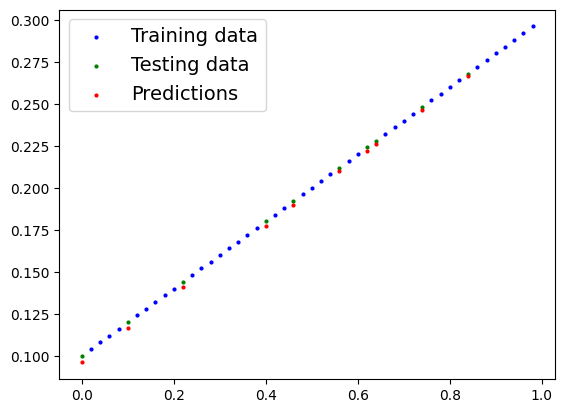

In [166]:
# 0. device agnostic code for data
X_train = X_train.to(device)
Y_train = Y_train.to(device)

# 1. Loss function
loss_fn = nn.L1Loss()                                                           # Mean absolute error

# 2. Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)               # Stochastic GRadient Descent

# 3. Training loop
epochs = 200                                                                    # number of epochs
torch.manual_seed(42)                                                           # fix the random seed

losses = []
for epoch in range(epochs):                                                     # iterate over number of epochs
    # training
    model_1.train()                                                             # set the model to training mode
    Y_pred = model_1(X_train)                                                   # calculate iteration predictions
    loss = loss_fn(Y_pred, Y_train)                                             # calculate iteration loss
    optimizer.zero_grad()                                                       # initialize optimizer
    loss.backward()                                                             # perform back-propagation
    optimizer.step()                                                            # update optimizer

    losses.append(float(loss))                                                  # store losses for visualization

# testing
model_1.eval()                                                                  # set to evaluation mode
with torch.inference_mode():                                                    # deactivate gradient tracking
    Y_pred = model_1(X_test)                                                    # calculate prediction

plot_predictions(X_train, Y_train, X_test, Y_test, predictions=Y_pred.cpu())    # plot prediction

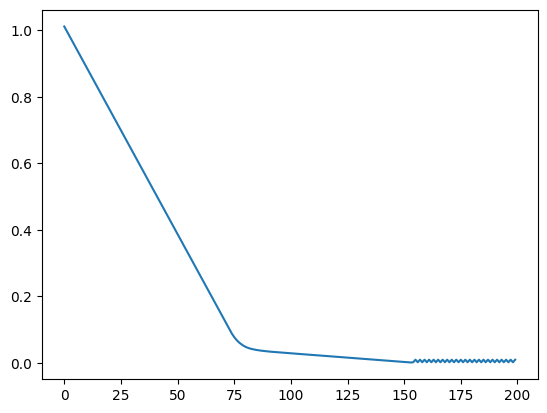

In [167]:
plt.plot(np.array(losses))

### Saving and loading the mode

In [169]:
from pathlib import Path

# create model directory (even if already there)
MODEL_PATH = Path("models")                                     # instantiate Path object
MODEL_PATH.mkdir(parents=True, exist_ok=True)                   # make new directory

# create the model's name
MODEL_NAME = "01_pytorch_workflow_model_1.pth"                  # model name
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME               

# save the state dict to file
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)         # save to file

In [171]:
# loading the model
loaded_model_1 = LinRegModel()                                  # instantiate the model object
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))   # loading the state dict
loaded_model_1.to(device)                                       # put to right device

loaded_model_1

LinRegModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

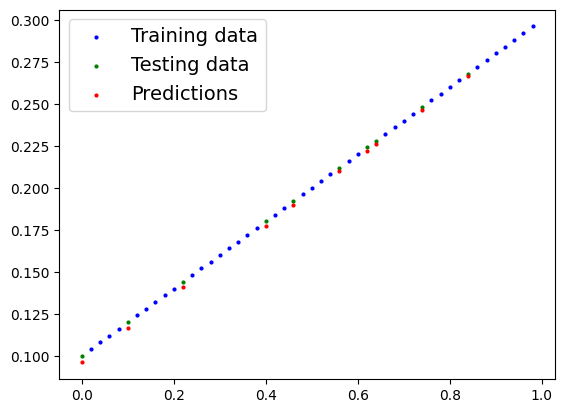

In [174]:
# evaluate the model
loaded_model_1.eval()                                           # set to evaluation mode

with torch.inference_mode():                                    # set torch to inference mode
    Y_pred_lm1 = loaded_model_1(X_test)                         # make predictions

# plot predictions
plot_predictions(X_train, Y_train, X_test, Y_test, predictions=Y_pred_lm1.cpu())

Y_pred == Y_pred_lm1                                            # check that they match the original model